## Load & Preprocess Dataset

In [1]:
import json
import random
import matplotlib.pyplot as plt

from typing import Dict, List, Any, Union

from dotenv import load_dotenv
from openai import AsyncOpenAI
from datasets import load_dataset

load_dotenv()

# get dataset
# For tutorial, we will use openai/gsm8k
dataset = load_dataset("openai/gsm8k", "main")
train_split = dataset["train"]
test_split = dataset["test"]
train_split = train_split.to_list()
test_split = test_split.to_list() 
pattern = "####"

random.seed(42)
random.shuffle(train_split)
random.shuffle(test_split)
train_split = train_split[:100]
test_split = test_split[:100]

from ape.common.types import DatasetItem

trainset: List[DatasetItem] = []
for item in train_split:
    split_answer = item["answer"].split(pattern)
    thought = split_answer[0]
    answer = split_answer[1]
    trainset.append(DatasetItem(
        inputs={"problem": item["question"]},
        outputs={"thought": thought, "answer": answer},
    ))
valset: List[DatasetItem] = []
for item in test_split:
    split_answer = item["answer"].split(pattern)
    thought = split_answer[0]
    answer = split_answer[1]
    valset.append(DatasetItem(
        inputs={"problem": item["question"]},
        outputs={"thought": thought, "answer": answer},
    ))


/Users/jypark/Desktop/weavel/Ape/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prepare Prompt to optimize

In [2]:
from ape.common import Prompt

# define prompt
system_prompt = """\
For given math problem, solve it step by step.

Question: {problem}

You MUST respond in JSON format with the following fields:
thought: the reasoning process of the problem solving.
answer: only return the answer without any explanation.
"""

json_schema = {
    "type": "json_schema", 
    "json_schema": {
        "name": "MathProblemSolving",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "thought": {
                    "type": "string",
                    "description": "The reasoning process of the problem solving"
                },
                "answer": {
                    "type": "string",
                    "description": "The answer to the question"
                }
            },
            "required": ["thought", "answer"],
            "additionalProperties": False
        }
    }
}


student_prompt = Prompt(
    messages=[
        {"role": "system", "content": system_prompt},
    ],
    model="gpt-4o-mini",
    temperature=0.0,
    name="student_prompt",
    response_format=json_schema,
)


## Prepare Generator, Metric, and Global Metric

In [3]:
from ape.common.generator import BaseGenerator
from ape.common.metric import BaseMetric
from ape.common.global_metric import BaseGlobalMetric
from ape.common.types import MetricResult, GlobalMetricResult

# define generator, metric, global metric
openai = AsyncOpenAI()
class MathSolver(BaseGenerator):
    async def generate(
        self,
        prompt: Prompt,
        inputs: Dict[str, Any],
    ) -> Union[Dict[str, Any], str]:
        retry_count = 0
        messages = prompt.format(**inputs).messages
        model = prompt.model
        response_format = prompt.response_format
        while retry_count < 3:
            try:
                response = await openai.chat.completions.create(
                    model=model,
                    messages=messages,
                    response_format=response_format,
                    temperature=0.0,
                )
                return json.loads(response.choices[0].message.content)
            except Exception as e:
                print(e)
                retry_count += 1
        return {
            "thought": "error",
            "topic": "",
        }

eval_json_schema = {
    "type": "json_schema", 
    "json_schema": {
        "name": "MathProblemSolvingEvaluation",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "thought": {
                    "type": "string",
                    "description": "The reasoning process of the problem solving evaluation"
                },
                "correctness": {
                    "type": "string",
                    "description": "The correctness of the problem solving"
                }
            },
            "required": ["thought", "correctness"],
            "additionalProperties": False
        }
    }
}

class MathMetricLLM(BaseMetric):
    async def compute(
        self,
        dataset_item: DatasetItem,
        pred: Dict[str, Any],
    ) -> MetricResult:
        openai = AsyncOpenAI()
        try:
            res = await openai.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {
                        "role": "system",
                        "content": """\
YOU ARE one of the GREATEST mathematicians, logicians, programmers, and AI scientists. You are intelligent and rational. You are prudent and cautious. Your mastery over Arithmetic, Combinatorics, Number Theory, Probability Theory, Algebra, Analysis, and Geometry is unparalleled. You THINK NATURAL, BROAD AND DEEP. Let's think step by step. 
Your job is to judge whether the "final_answer" is correct based on "ground_truth_answer", do not be strict on the format, but check the content. Notice that unsolved half results are not Correct. 
Problem: {question_content}
Is the final_answer correct, given the ground truth answer? Reply with Correct, Wrong or Unknown. 
"final_answer": "{final_answer}", "ground_truth_answer": "{ground_truth_answer}"

You MUST respond in JSON format like below:
{{
    "thought": "...",
    "correctness": "<correctness>", One of "Correct", "Wrong", "Unknown"
}}
""".format(question_content=dataset_item["inputs"]["problem"], final_answer=pred["answer"], ground_truth_answer=dataset_item["outputs"]["answer"])
                    }
                ],
                response_format=eval_json_schema,
                temperature=0.0,
            )
            res_json = json.loads(res.choices[0].message.content)
            # print(dataset_item["outputs"]["answer"], pred["answer"], res_json["correctness"])
            if res_json["correctness"] == "Correct":
                return MetricResult(
                    score=1.0,
                )
            else:
                return MetricResult(
                    score=0.0,
                )
        except Exception as e:
            print(e)
            # print(pred)
            return MetricResult(
                score=0.0,
            )

class GlobalAverageMetric(BaseGlobalMetric):
    async def compute(
        self,
        results: List[MetricResult],
    ) -> GlobalMetricResult:
        try:
            scores = [result.score for result in results]
            return GlobalMetricResult(
                score=sum(scores) / len(scores) if len(results) > 0 else 0.0,
            )
        except Exception as e:
            # print("Error in GlobalEmotionMetric: ", e)
            return GlobalMetricResult(
                score=0.0,
            )
        

## Select Trainer & Run

In [4]:
from ape.core.trainer import (
    TextGradientTrainer,
    ExpelTrainer,
    FewShotTrainer,
    EvoPromptTrainer,
    DspyMiproTrainer,
    OptunaTrainer,
)

# define trainer 
trainer = FewShotTrainer(
    generator=MathSolver(),
    metric=MathMetricLLM(),
    global_metric=GlobalAverageMetric(),
    testmode=True # If True, trainer will run prompts for validation set and save results.
)

# run trainer
optimized_prompt, report = await trainer.train(
    prompt=student_prompt,
    trainset=trainset,
    valset=valset,
)


/Users/jypark/Desktop/weavel/Ape/venv/lib/python3.11/site-packages/pydantic/main.py:390: UserWarning: Pydantic serializer warnings:
  Expected `PromptTokensDetails` but got `dict` with value `{'audio_tokens': None, 'cached_tokens': 0}` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Unterminated string starting at: line 2 column 14 (char 15)
Unterminated string starting at: line 1 column 12 (char 11)
Unterminated string starting at: line 2 column 14 (char 15)
Unterminated string starting at: line 2 column 14 (char 15)
Unterminated string starting at: line 2 column 16 (char 17)
Unterminated string starting at: line 2 column 14 (char 15)
Unterminated string starting at: line 2 column 14 (char 15)
Unterminated string starting at: line 2 column 16 (char 17)
Unterminated string starting at: line 2 column 16 (char 17)
Unterminated string starting at: line 2 column 16 (char 17)
Unterminated string starting at: line 2 column 14 (char 15)
Unterminated string starting at: line 2 column 14 (char 15)
Unterminated string starting at: line 1 column 12 (char 11)
Unterminated string starting at: line 2 column 14 (char 15)
Unterminated string starting at: line 2 column 14 (char 15)
Unterminated string starting at: line 2 column 16 (char 17)
Unterminated string starting at: line 2 

## Print Optimized Prompt

In [5]:
# print optimized prompt
for message in optimized_prompt.messages:
    print(message)

{'role': 'system', 'content': 'For given math problem, solve it step by step.\n\nQuestion: {problem}\n\nYou MUST respond in JSON format with the following fields:\nthought: the reasoning process of the problem solving.\nanswer: only return the answer without any explanation.\n\nExample:\n{_FEWSHOT_}'}


## Print Benchmark Test Results

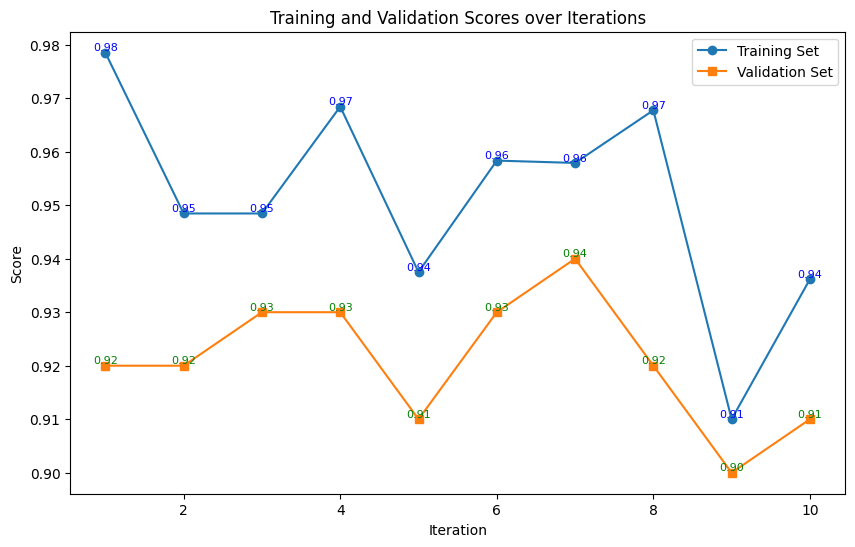

In [6]:
# visualize experiment results
def visualize_scores(report):
    scores = report.scores
    trainset_scores = [score["score"] for score in scores]
    valset_scores = [score["val_score"] for score in scores]
    iterations = range(1, len(trainset_scores) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(iterations, trainset_scores, label='Training Set', marker='o')
    plt.plot(iterations, valset_scores, label='Validation Set', marker='s')
    
    for i, (train_score, val_score) in enumerate(zip(trainset_scores, valset_scores)):
        plt.text(iterations[i], train_score, f'{train_score:.2f}', 
                    ha='center', va='bottom', fontsize=8, color='blue')
        plt.text(iterations[i], val_score, f'{val_score:.2f}', 
                    ha='center', va='bottom', fontsize=8, color='green')

    plt.title('Training and Validation Scores over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

visualize_scores(report)